In [1]:
from easygui import fileopenbox
from librosa import load
import os
import winsound

## Selecting the audio file manually

---

In [2]:
default_path_to_dataset = os.path.abspath(os.path.join("Datasets","RAVDESS_DATASET"))
choosen_path = fileopenbox(msg="Choose a voice sample",title="Test Audio Selector",default=default_path_to_dataset,filetypes="*.wav")

## Play The Selected Audio

In [3]:
winsound.PlaySound(choosen_path,winsound.SND_FILENAME)

# Extract The Original Emotion Details from File Name
---

In [4]:
emotion_dictionary = {
        1:'neutral',
        2:'calm',
        3:'happy',
        4:'sad',
        5:'angry',
        6:'fearful',
        7:'disgust',
        8:'surprised'
    }

In [5]:
def find_emotion(filename):
    """
        @filename : taking the voice input filename 
        
        @returning emotion code by extracting it 
    """
    parta,_ = filename.split('.')
    codes = parta.split('-')
    #print(*codes)
    return int(codes[2])

In [6]:
file_name = choosen_path.split("\\")[-1]
original_emotion = find_emotion(file_name)
print(emotion_dictionary[original_emotion])

calm


## Encoding Categories
---

In [31]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model
import numpy as np

In [32]:
categories = np.array(list(emotion_dictionary.values())).reshape(-1,1)
print(categories)
Ohe = OneHotEncoder(handle_unknown="ignore")
v = Ohe.fit_transform(categories).toarray()
Ohe.get_feature_names_out()

[['neutral']
 ['calm']
 ['happy']
 ['sad']
 ['angry']
 ['fearful']
 ['disgust']
 ['surprised']]


array(['x0_angry', 'x0_calm', 'x0_disgust', 'x0_fearful', 'x0_happy',
       'x0_neutral', 'x0_sad', 'x0_surprised'], dtype=object)

In [33]:
print(v)

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


# Extracting The Features of the selected Audio 
-----

### Feature Extraction Function

----

In [34]:
import librosa
import numpy as np

In [35]:
def extract_features(file_path):
    data,sample_rate = load(file_path,duration = 2.5) 
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return np.array(result)

In [36]:
from sklearn.preprocessing import StandardScaler

-----
# Main Audio Feature Extraction
----

In [37]:
aud_features = np.array(extract_features(choosen_path)).reshape(-1,1)
# scaler = StandardScaler()
# aud_features = scaler.fit_transform(aud_features)
aud_features =aud_features.reshape(1,-1,1)
aud_features
print(aud_features.shape)

(1, 162, 1)


# Select the model you want to use
----

In [53]:
model_path = fileopenbox(default=os.path.abspath("Models"),filetypes="\*.h5")

----
### Loading the Model & Compiling it

In [54]:
model = load_model(model_path)

# Prediction

In [55]:
ans = model.predict(aud_features)
ans

array([[0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

----
# Predicted Emotion
----

In [56]:
Ohe.inverse_transform(ans)[0][0]

'sad'

----------
# Original Emotion Of the Same Audio
----


In [57]:
emotion_dictionary[original_emotion]

'calm'

# If Both Orignal and Prediction are Same or Not
----

In [58]:
Ohe.inverse_transform(ans)[0][0] == emotion_dictionary[original_emotion]

False

In [59]:
import pandas as pd
data_df =  pd.read_csv("Features\\Final_Test_Data.csv",index_col=False)
data_df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.300184,0.738577,0.742603,0.724332,0.726936,0.683394,0.653090,0.696985,0.748464,0.751690,...,0.000004,0.000003,0.000002,0.000002,0.000005,0.000008,5.375256e-06,2.270875e-06,1.642310e-07,neutral
1,0.270354,0.683518,0.730694,0.716595,0.679522,0.675306,0.669987,0.631418,0.686722,0.713734,...,0.000007,0.000007,0.000007,0.000007,0.000012,0.000009,8.465726e-06,2.638482e-06,1.788962e-07,neutral
2,0.307369,0.716178,0.761089,0.758008,0.758388,0.734855,0.649470,0.630941,0.680735,0.738601,...,0.000013,0.000013,0.000015,0.000020,0.000028,0.000048,2.483219e-05,8.083573e-06,6.468821e-07,neutral
3,0.298019,0.768713,0.744220,0.736126,0.739507,0.687656,0.680441,0.684369,0.737645,0.710171,...,0.000020,0.000019,0.000025,0.000080,0.000040,0.000037,3.107767e-05,1.029449e-05,6.636600e-07,neutral
4,0.154713,0.622998,0.607691,0.712971,0.753272,0.674684,0.643868,0.681713,0.636211,0.655982,...,0.000002,0.000002,0.000002,0.000002,0.000005,0.000001,9.390579e-07,3.889406e-07,3.605377e-08,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.283275,0.682935,0.611837,0.554851,0.582324,0.586729,0.563456,0.609359,0.620698,0.627672,...,0.000434,0.000342,0.000196,0.000177,0.000099,0.000138,1.130562e-04,4.429360e-05,5.434214e-06,surprised
1436,0.191298,0.716018,0.711515,0.630057,0.613776,0.545133,0.462726,0.490436,0.521717,0.525032,...,0.001142,0.001424,0.001061,0.001011,0.001184,0.001036,8.029558e-04,2.153141e-04,2.631514e-05,surprised
1437,0.196438,0.685374,0.677752,0.573350,0.545138,0.522108,0.551561,0.543446,0.491266,0.526830,...,0.001348,0.001701,0.001115,0.000949,0.000899,0.000693,5.340261e-04,1.162562e-04,6.957946e-06,surprised
1438,0.199051,0.607357,0.599170,0.603107,0.588351,0.588026,0.622353,0.626575,0.553910,0.519906,...,0.005899,0.006859,0.005612,0.006526,0.006053,0.006471,5.336353e-03,1.802893e-03,1.158740e-04,surprised


In [60]:
X=data_df.iloc[:,:-1].values
Y = data_df['labels'].values

In [61]:
Y

array(['neutral', 'neutral', 'neutral', ..., 'surprised', 'surprised',
       'surprised'], dtype=object)

In [62]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
Y = Ohe.fit_transform(Y.reshape(-1,1)).toarray()

In [63]:
# making our data compatible to model.
x_test = np.expand_dims(X, axis=2)

x_test, Y

(array([[[ 1.7719921 ],
         [ 1.42985937],
         [ 1.32215036],
         ...,
         [-0.32874941],
         [-0.25852626],
         [-0.14610257]],
 
        [[ 1.28272328],
         [ 0.78989864],
         [ 1.19535832],
         ...,
         [-0.32791535],
         [-0.25835563],
         [-0.14609369]],
 
        [[ 1.88982298],
         [ 1.16950773],
         [ 1.51895986],
         ...,
         [-0.32349839],
         [-0.25582812],
         [-0.14581044]],
 
        ...,
 
        [[ 0.07037775],
         [ 0.81147625],
         [ 0.63171893],
         ...,
         [-0.18607773],
         [-0.20561638],
         [-0.14199065]],
 
        [[ 0.11323883],
         [-0.09532548],
         [-0.20488883],
         ...,
         [ 1.10996883],
         [ 0.57728906],
         [-0.07606886]],
 
        [[ 1.31831726],
         [ 0.53234004],
         [ 0.50951539],
         ...,
         [ 0.21553224],
         [ 0.03029333],
         [-0.06078106]]]),
 array([[0., 0., 0.

In [64]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,Y)[1]*100 , "%")

45/45 [==============================] - 0s 7ms/step - loss: 0.7822 - accuracy: 0.8319
Accuracy of our model on test data :  83.1944465637207 %


In [65]:
pred_test = model.predict(x_test)
y_pred = Ohe.inverse_transform(pred_test)

y_test = Ohe.inverse_transform(Y)

In [66]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.tail(10)

,Predicted Labels,Actual Labels
1430,disgust,disgust
1431,disgust,disgust
1432,surprised,surprised
1433,surprised,surprised
1434,surprised,surprised
1435,surprised,surprised
1436,surprised,surprised
1437,surprised,surprised
1438,surprised,surprised
1439,surprised,surprised


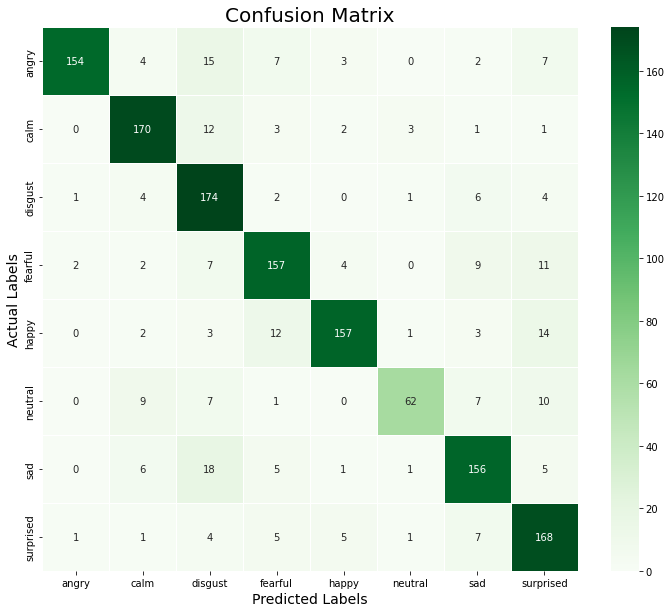

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in Ohe.categories_] , columns = [i for i in Ohe.categories_])
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()